In [1]:
import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import pandas as pd
from sktime.transformations.panel.rocket import Rocket, MiniRocketMultivariate
from sklearn.model_selection import StratifiedKFold
import pickle
from glob import glob
import time
from noise import decompress_pickle
INPUT_DATA_PATH = '../input-data/'
MODEL_PATH = './models/'
data = decompress_pickle(INPUT_DATA_PATH + 'cycle_data')

In [2]:
def open_folds(cycle, train_test, X_y, v_i):
    """
    Parameters:
        cycle      : which cycle, ex.: 'cycle_1' (1, 2, 4, 8, 16, 32)
        train_test : if it is the train ot test set, ex: 'train' (train, test)
        X_y        : if it is the X or y set, ex.: 'X' (X, y)
        v_i        : if it is a voltage or current signal, ex.: 'i' (v, i)
    Return:
        list : each fold is in a position.
    """
    paths = list(map(lambda x: x.split('.pbz2')[0], glob(INPUT_DATA_PATH + 
                                                         f'folds/{v_i}/{cycle}/{X_y}_{train_test}_fold_[0-9]*.pbz2')))
    paths.sort(key = lambda x: int(x.split('_')[-1]))
    data_list = []
    for path in paths:
        folder_pos = int(path.split('/')[-1].split('_')[-1]) - 1
        fold = decompress_pickle(path)
        data_list.insert(folder_pos, fold)
    return data_list

In [3]:
def find_max(X):
    max = np.max(X)
    min = np.abs(np.min(X))
    if max > min:
        return max
    else:
        return min

In [4]:
def format_dataframe(data):
    cols = int(data.shape[0] / 4)
    shaped_data = data.reshape((4, cols)).T
    s1 = pd.Series(shaped_data[:, 0])
    s2 = pd.Series(shaped_data[:, 1])
    s3 = pd.Series(shaped_data[:, 2])
    s4 = pd.Series(shaped_data[:, 3])
    dicio = {'A': [], 'B': [], 'C': [], 'Z': []}
    dicio['A'].append(s1)
    dicio['B'].append(s2)
    dicio['C'].append(s3)
    dicio['Z'].append(s4)
    return pd.DataFrame(dicio)

In [5]:
X_train = decompress_pickle(INPUT_DATA_PATH + f'folds/i/cycle_1/X_train')
y_train = decompress_pickle(INPUT_DATA_PATH + f'folds/i/cycle_1/y_train')
X_val = decompress_pickle(INPUT_DATA_PATH + f'folds/i/cycle_1/X_val')
y_val = decompress_pickle(INPUT_DATA_PATH + f'folds/i/cycle_1/y_val')


In [6]:
max_list = [0, 0, 0, 0]
for k, v in {'A': 0, 'B': 1, 'C': 2, 'Z': 3}.items():
    for row in X_train[k]:
        max_value = find_max(row)
        if max_value > max_list[v]:
            max_list[v] = max_value


In [7]:
max_list

[6075.605580855044, 6077.654717323059, 6068.883200964617, 3100.6294160039506]

In [8]:
X_train_norm = X_train.copy()
X_train_norm['A'] = X_train_norm['A'] / max_list[0]
X_train_norm['B'] = X_train_norm['B'] / max_list[1]
X_train_norm['C'] = X_train_norm['C'] / max_list[2]
X_train_norm['Z'] = X_train_norm['Z'] / max_list[3]

X_val_norm = X_val.copy()
X_val_norm['A'] = X_val_norm['A'] / max_list[0]
X_val_norm['B'] = X_val_norm['B'] / max_list[1]
X_val_norm['C'] = X_val_norm['C'] / max_list[2]
X_val_norm['Z'] = X_val_norm['Z'] / max_list[3]

In [9]:
max_list2 = [0, 0, 0, 0]
for k, v in {'A': 0, 'B': 1, 'C': 2, 'Z': 3}.items():
    for row in X_train_norm[k]:
        max_value = find_max(row)
        if max_value > max_list2[v]:
            max_list2[v] = max_value

In [10]:
max_list2

[1.0, 1.0, 1.0, 1.0]

In [11]:
train_X_cycle_1 = open_folds('cycle_1', 'train', 'X', 'i')
train_y_cycle_1 = open_folds('cycle_1', 'train', 'y', 'i')
test_X_cycle_1 = open_folds('cycle_1', 'test', 'X', 'i')
test_y_cycle_1 = open_folds('cycle_1', 'test', 'y', 'i')

In [12]:
num_features = 150
minirocket = MiniRocketMultivariate(num_features=num_features)
minirocket.fit(X_train_norm)
X_val_transform = minirocket.transform(X_val_norm)


In [13]:
scores = []
count = -1
s = time.time()
for X_tr, y_tr, X_te, y_te in zip(train_X_cycle_1, train_y_cycle_1,
                                  test_X_cycle_1, test_y_cycle_1):

    # Normalização
    X_tr_norm = X_tr.copy()
    X_tr_norm['A'] = X_tr_norm['A'] / max_list[0]
    X_tr_norm['B'] = X_tr_norm['B'] / max_list[1]
    X_tr_norm['C'] = X_tr_norm['C'] / max_list[2]
    X_tr_norm['Z'] = X_tr_norm['Z'] / max_list[3]

    X_te_norm = X_te.copy()
    X_te_norm['A'] = X_te_norm['A'] / max_list[0]
    X_te_norm['B'] = X_te_norm['B'] / max_list[1]
    X_te_norm['C'] = X_te_norm['C'] / max_list[2]
    X_te_norm['Z'] = X_te_norm['Z'] / max_list[3]

    # Treinamento
    X_tr_transform = minirocket.transform(X_tr_norm)
    X_te_transform = minirocket.transform(X_te_norm)
    clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
    clf.fit(X_tr_transform, y_tr)

    # Avaliação do modelo
    score = clf.score(X_te_transform, y_te)
    scores.append(score)
    if len(scores) == 1:
        pickle.dump(clf, open(MODEL_PATH + 'minirocket_model_cycle_1.pkl', 'wb'))
        # compressed_pickle(MODEL_PATH + 'rocket_model_cycle_1', clf)
    else:
        if score > scores[count]:
            pickle.dump(clf, open(MODEL_PATH + 'minirocket_model_cycle_1.pkl', 'wb'))
            # compressed_pickle(MODEL_PATH + 'rocket_model_cycle_1', clf)
    count += 1
e = time.time()
final_scores = np.array(scores)
print(f'Acurácia em cada fold:\n {np.round(final_scores * 100, decimals=2)}')
print(f'\nMédia da acurácia: {np.mean(final_scores) * 100:.2f}%')
print(f'Desvio padrão da acurácia: {np.std(final_scores) * 100:.2f}%)')
print(f'Tempo necessário para treinamento {e-s} segundos')

Acurácia em cada fold:
 [100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]

Média da acurácia: 100.00%
Desvio padrão da acurácia: 0.00%)
Tempo necessário para treinamento 11.581993579864502 segundos


In [14]:
with open(MODEL_PATH + 'minirocket_model_cycle_1.pkl', 'rb') as f:
    model = pickle.load(f)

In [15]:
model.score(X_val_transform, y_val)

1.0

In [16]:
y_pred = model.predict(X_val_transform)

<ipython-input-17-03bb8e920c6e>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(confusion_matrix.index, rotation=0, fontsize="14", va="center")
<ipython-input-17-03bb8e920c6e>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(confusion_matrix.columns, rotation=0, fontsize="14", va="center")


<AxesSubplot:xlabel='Predito', ylabel='Real'>

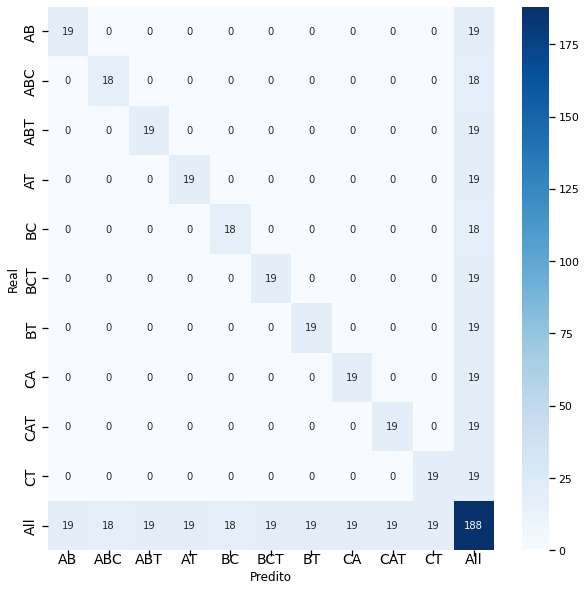

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt 
cmap='Blues'
font=10
figsize=(10,10)
sns.set_context("notebook")
data = {'Real':    y_val,
        'Predito': y_pred}
df = pd.DataFrame(data, columns=['Real','Predito'])
confusion_matrix = pd.crosstab(df['Real'], df['Predito'], rownames=['Real'], colnames=['Predito'], margins = True)
fig, ax = plt.subplots(figsize=figsize)
ax.set_yticklabels(confusion_matrix.index, rotation=0, fontsize="14", va="center")
ax.set_xticklabels(confusion_matrix.columns, rotation=0, fontsize="14", va="center")
sns.heatmap(confusion_matrix, annot=True, fmt='g', annot_kws={"fontsize": font}, cmap=cmap)

In [18]:
import plotly.express as px
cm = confusion_matrix.drop('All', axis=1).drop('All', axis=0)
fig = px.imshow(cm, color_continuous_scale='blues')
fig.show()



In [23]:
import plotly.figure_factory as ff

data = {'Real':    y_val,
        'Predito': y_pred}
df = pd.DataFrame(data, columns=['Real','Predito'])
confusion_matrix = pd.crosstab(df['Real'], df['Predito'], rownames=['Real'], colnames=['Predito'], margins = True)
cm = confusion_matrix.drop('All', axis=1).drop('All', axis=0)

c = cm.values[::-1]
x = list(cm.index)
y = x[::-1]
c_text = [[str(y) for y in x] for x in c]

fig = ff.create_annotated_heatmap(c, x=x, y=y, annotation_text=c_text, colorscale='blues')

# add title
fig.update_layout(title_text='<i><b>Matriz de Confusão</b></i>',
                  #xaxis = dict(title='Valores Preditos'),
                  #yaxis = dict(title='Valores Reais')
                  title_x=0.5,
                  autosize=False,
                  width=500,
                  height=500,
                 )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.12,
                        showarrow=False,
                        text="Valores Preditos",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.2,
                        y=0.5,
                        textangle=270,
                        showarrow=False,
                        text="Valores Reais",
                        xref="paper",
                        yref="paper"))
fig.write_image("fig1.svg")
fig.show()

In [16]:
num_kernels = 10000
rocket = Rocket(num_kernels=num_kernels)
rocket.fit(X_train_norm)
X_val_transform = rocket.transform(X_val_norm)

In [17]:
scores = []
count = -1
s = time.time()
for X_tr, y_tr, X_te, y_te in zip(train_X_cycle_1, train_y_cycle_1,
                                  test_X_cycle_1, test_y_cycle_1):

    # Normalização
    X_tr_norm = X_tr.copy()
    X_tr_norm['A'] = X_tr_norm['A'] / max_list[0]
    X_tr_norm['B'] = X_tr_norm['B'] / max_list[1]
    X_tr_norm['C'] = X_tr_norm['C'] / max_list[2]
    X_tr_norm['Z'] = X_tr_norm['Z'] / max_list[3]

    X_te_norm = X_te.copy()
    X_te_norm['A'] = X_te_norm['A'] / max_list[0]
    X_te_norm['B'] = X_te_norm['B'] / max_list[1]
    X_te_norm['C'] = X_te_norm['C'] / max_list[2]
    X_te_norm['Z'] = X_te_norm['Z'] / max_list[3]

    # Treinamento
    X_tr_transform = rocket.transform(X_tr_norm)
    X_te_transform = rocket.transform(X_te_norm)
    clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
    clf.fit(X_tr_transform, y_tr)

    # Avaliação do modelo
    score = clf.score(X_te_transform, y_te)
    scores.append(score)
    if len(scores) == 1:
        pickle.dump(clf, open(MODEL_PATH + 'rocket_model_cycle_1.pkl', 'wb'))
        # compressed_pickle(MODEL_PATH + 'rocket_model_cycle_1', clf)
    else:
        if score > scores[count]:
            pickle.dump(clf, open(MODEL_PATH + 'rocket_model_cycle_1.pkl', 'wb'))
            # compressed_pickle(MODEL_PATH + 'rocket_model_cycle_1', clf)
    count += 1
e = time.time()
final_scores = np.array(scores)
print(f'Acurácia em cada fold:\n {np.round(final_scores * 100, decimals=2)}')
print(f'\nMédia da acurácia: {np.mean(final_scores) * 100:.2f}%')
print(f'Desvio padrão da acurácia: {np.std(final_scores) * 100:.2f}%)')
print(f'Tempo necessário para treinamento {e-s} segundos')

Acurácia em cada fold:
 [100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]

Média da acurácia: 100.00%
Desvio padrão da acurácia: 0.00%)
Tempo necessário para treinamento 473.60908007621765 segundos


In [18]:
with open(MODEL_PATH + 'rocket_model_cycle_1.pkl', 'rb') as f:
    model = pickle.load(f)

In [19]:
model.score(X_val_transform, y_val)

1.0

# Using pipelines

https://www.kaggle.com/baghern/a-deep-dive-into-sklearn-pipelines